### ENVIRONMENTAL RASTERS (SUMMER, 2025)

Workflow:
- Load manually downloaded Landsat rasters.
- Keep only necessary bands B2–B7 + QA_PIXEL for calculations.
- Compute NDVI, NDWI, NDBI.
- Perform cloud masking.
- Zonal stats over census tracts.
- Output final tract-level summer 2025 metrics.

For my own reference because this is a long and complicated notebook.

| INDEX                         | BAND              |
|---|---|
| Blue                          | B2                |
| Green                         | B3                |
| Red                           | B4                |
| NIR (Near Infrared)           | B5                |
| SWIR1 (Shortwave Infrared 1)  | B6                |
| SWIR2 (Shortwave Infrared)    | B7                |
| Pixel QA                      | QA_PIXEL          |
| ANG                           | Solar Geometry    |

In [1]:
# Modules.
import os
from pathlib import Path
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import geopandas as gpd
from tqdm import tqdm
from rasterstats import zonal_stats

In [2]:
# Paths.
landsat_dir = Path("data/raster/landsat")

nlcd_tree_path = Path("data/raster/nlcd_raster/nlcd_tree_canopy_2023.tiff")
nlcd_impervious_path = Path("data/raster/nlcd_raster/nyc_ncld_impervious_2024.tiff")
nlcd_landcov_path = Path("data/raster/nlcd_raster/nyc_ncld_land_cover_2024.tiff")

tracts_path = Path("data/nyc_tracts_2020/nyc_tracts_2020.shp")

output_dir = Path("data/raster/processed")
output_dir.mkdir(parents = True, exist_ok = True)

tracts = gpd.read_file(tracts_path).to_crs(4326)

# Dissolved NYC boundary to Shapely.
nyc_boundary = tracts.union_all()

In [3]:
# Landsat grouping helper functions.
def extract_band_tag(file_path):
    """
    Extracts SR_B4 or QA_PIXEL from filename.
    Works for:
        LC08_..._SR_B4.TIF
        LC08_..._QA_PIXEL.TIF
    """
    name = file_path.name.replace(".TIF", "").replace(".tif", "")
    parts = name.split("_")

    if len(parts) >= 2:
        return "_".join(parts[-2:])
    
    return parts[-1]

def group_scenes(landsat_dir):
    """Groups files into scenes using first 7 underscore texts."""
    scenes = {}
    for file_path in landsat_dir.glob("*"):
        if file_path.is_dir():
            continue

        name = file_path.name

        if ("SR_B" not in name and "QA_PIXEL" not in name):
            continue

        tokens = name.split("_")
        if len(tokens) < 7:
            continue

        scene_id = "_".join(tokens[:7])
        scenes.setdefault(scene_id, []).append(file_path)

    return scenes

scene_dict = group_scenes(landsat_dir)
print("Scenes:", len(scene_dict))

# Required bands.
target_bands = {"SR_B2","SR_B3","SR_B4","SR_B5","SR_B6","SR_B7","QA_PIXEL"}

usable_scenes = []

for scene_id, files in scene_dict.items():
    tags = {extract_band_tag(f) for f in files}

    if target_bands.issubset(tags):
        usable_scenes.append(scene_id)

print("Usable scenes:", len(usable_scenes))
usable_scenes[:10]

Scenes: 37
Usable scenes: 37


['LC08_L2SP_013031_20250611_20250618_02_T1',
 'LC08_L2SP_013031_20250627_20250710_02_T1',
 'LC08_L2SP_013031_20250729_20250807_02_T1',
 'LC08_L2SP_013031_20250814_20250821_02_T1',
 'LC08_L2SP_013031_20250830_20250903_02_T1',
 'LC08_L2SP_013032_20250611_20250618_02_T1',
 'LC08_L2SP_013032_20250713_20250726_02_T1',
 'LC08_L2SP_013032_20250729_20250807_02_T1',
 'LC08_L2SP_013032_20250814_20250821_02_T1',
 'LC08_L2SP_013032_20250830_20250903_02_T1']

In [4]:
# Cloud masking helper function.
def cloud_mask(qa_array):
    """Return True for cloud-free pixels."""
    qa = qa_array.astype(np.uint16)
    
    cloud  = (1 << 3)

    return ((qa & cloud) == 0)

# Load and crop to NYC helper function.
def load_and_crop(band_path, geom):
    """Crop a raster to NYC boundary (handles MultiPolygons)."""
    with rasterio.open(band_path) as src:

        # Ensure geometry is in a list
        if hasattr(geom, "geoms"):  # MultiPolygon
            geom_list = list(geom.geoms)
        else:
            geom_list = [geom]

        # Reproject all polygons
        geom_proj = gpd.GeoSeries(geom_list, crs=4326).to_crs(src.crs)

        out_image, out_transform = mask(src, geom_proj.geometry, crop=True)

        profile = src.profile.copy()
        profile.update({
            "height": out_image.shape[1],
            "width":  out_image.shape[2],
            "transform": out_transform
        })

        return out_image[0].astype(np.float32), profile

In [5]:
# Prepare for landsat calculations.
sum_ndvi = None
sum_ndwi = None
sum_ndbi = None
count = None

ref_profile = None
ref_shape = None

In [7]:
# Get summer Landsat index.
for scene_id in tqdm(usable_scenes):
    band_map = {extract_band_tag(f): f for f in scene_dict[scene_id]}

    try:
        red, prof = load_and_crop(band_map["SR_B4"], nyc_boundary); current_profile = prof
        nir, _ = load_and_crop(band_map["SR_B5"], nyc_boundary)
        green, _    = load_and_crop(band_map["SR_B3"], nyc_boundary)
        blue, _ = load_and_crop(band_map["SR_B2"], nyc_boundary)
        swir1, _ = load_and_crop(band_map["SR_B6"], nyc_boundary)
        swir2, _ = load_and_crop(band_map["SR_B7"], nyc_boundary)
        qa, _ = load_and_crop(band_map["QA_PIXEL"], nyc_boundary)

    except Exception as e:
        print("Failed:", scene_id, e)

        continue

    good_pixels = cloud_mask(qa)

    if good_pixels.sum() == 0:
        print("No valid pixels:", scene_id)

        continue

    # Mask clouds
    red = np.where(good_pixels, red, np.nan)
    nir = np.where(good_pixels, nir, np.nan)
    green = np.where(good_pixels, green, np.nan)
    blue = np.where(good_pixels, blue, np.nan)
    swir1 = np.where(good_pixels, swir1, np.nan)
    swir2 = np.where(good_pixels, swir2, np.nan)

    # Indices
    ndvi = (nir - red) / (nir + red)
    ndwi = (green - nir) / (green + nir)
    ndbi = (swir1 - nir) / (swir1 + nir)

    # Setup reference grid
    if sum_ndvi is None:
        ref_profile = current_profile
        ref_shape = ndvi.shape
        sum_ndvi = np.zeros(ref_shape, dtype = np.float32)
        sum_ndwi = np.zeros(ref_shape, dtype = np.float32)
        sum_ndbi = np.zeros(ref_shape, dtype = np.float32)
        count = np.zeros(ref_shape, dtype = np.float32)

    # Alignment helper
    def force_align(arr):
        if arr.shape == ref_shape:
            return arr
        destination = np.full(ref_shape, np.nan, dtype = np.float32)
        reproject(
            source=arr,
            destination=destination,
            src_transform=current_profile["transform"],
            src_crs=current_profile["crs"],
            dst_transform=ref_profile["transform"],
            dst_crs=ref_profile["crs"],
            src_nodata=np.nan,
            dst_nodata=np.nan,
            resampling=Resampling.bilinear
        )
        return destination

    ndvi = force_align(ndvi)
    ndwi = force_align(ndwi)
    ndbi = force_align(ndbi)

    valid = ~np.isnan(ndvi)
    sum_ndvi[valid] += ndvi[valid]
    sum_ndwi[valid] += ndwi[valid]
    sum_ndbi[valid] += ndbi[valid]
    count[valid] += 1

# Safety check
if count is None or count.sum() == 0:
    raise RuntimeError("No scenes processed.")

  0%|          | 0/37 [00:00<?, ?it/s]C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\233292818.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)
C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\233292818.py:36: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (green + nir)
C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\233292818.py:37: RuntimeWarning: invalid value encountered in divide
  ndbi = (swir1 - nir) / (swir1 + nir)
  3%|▎         | 1/37 [00:01<00:44,  1.23s/it]C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\233292818.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)
C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\233292818.py:36: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (green + nir)
C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\233292818.py:37: RuntimeWarning: invalid value encountered in divide
  ndbi = (swir1 - nir

In [8]:
# Final summer averages.
ndvi_final = sum_ndvi / count
ndwi_final = sum_ndwi / count
ndbi_final = sum_ndbi / count

print("NDVI:", ndvi_final)
print("\nNDWI:", ndwi_final)
print("\nNDBI:", ndbi_final)

NDVI: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]

NDWI: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]

NDBI: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\2156252763.py:2: RuntimeWarning: invalid value encountered in divide
  ndvi_final = sum_ndvi / count
C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\2156252763.py:3: RuntimeWarning: invalid value encountered in divide
  ndwi_final = sum_ndwi / count
C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\2156252763.py:4: RuntimeWarning: invalid value encountered in divide
  ndbi_final = sum_ndbi / count


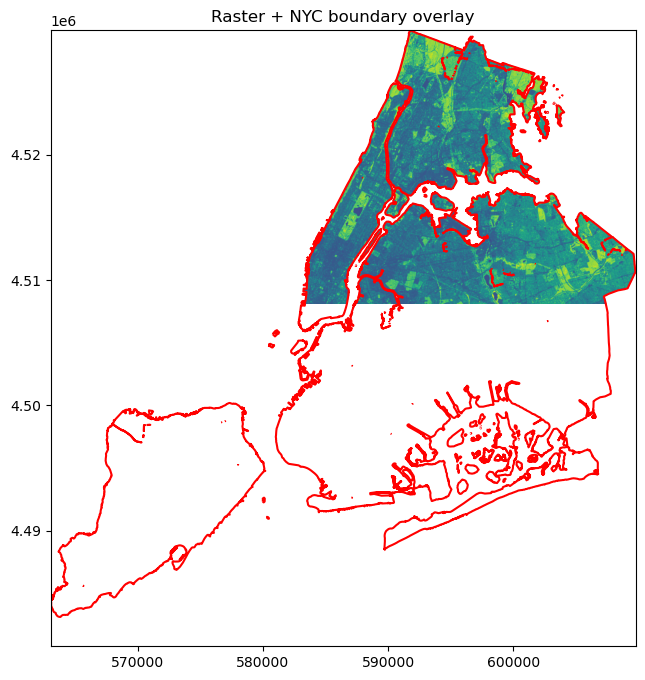

In [9]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# ------------------------------------------
# Paths
# ------------------------------------------
tif_path = "data/raster/processed/ndvi_summer_2025.tif"
tracts_path = "data/nyc_tracts_2020/nyc_tracts_2020.shp"

# ------------------------------------------
# Load raster
# ------------------------------------------
with rasterio.open(tif_path) as src:
    raster_crs = src.crs
    raster_bounds = src.bounds

    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax, cmap="viridis")
    ax.set_title("Raster + NYC boundary overlay")

# ------------------------------------------
# Load & reproject NYC boundary
# ------------------------------------------
tracts = gpd.read_file(tracts_path)
nyc_boundary = tracts.union_all()               # dissolve
gdf_boundary = gpd.GeoSeries([nyc_boundary], crs=tracts.crs)

# Reproject to raster CRS
gdf_boundary = gdf_boundary.to_crs(raster_crs)

# ------------------------------------------
# Overlay geometry outline
# ------------------------------------------
gdf_boundary.boundary.plot(ax=ax, color="red", linewidth=1.5)

plt.show()


In [10]:
# Save rasters.
profile = ref_profile.copy()
profile.update(
    dtype = np.float32,
    count = 1,
    nodata = np.nan,
    compress = "lzw"
)

In [11]:
# Save rasters with print checks.
def save_raster(arr, path):
    with rasterio.open(path, "w", **profile) as destination:
        destination.write(arr.astype(np.float32), 1)

print("Saving:")

save_raster(ndvi_final, output_dir / "ndvi_summer_2025.tif")
save_raster(ndwi_final, output_dir / "ndwi_summer_2025.tif")
save_raster(ndbi_final, output_dir / "ndbi_summer_2025.tif")

print("Done.")

Saving:
Done.


In [12]:
# Zonal statistics for NCLD.
def zonal_mean(rpath, gdf_or_geom):
    """Apply CRS zonal mean for tracts or city boundary."""
    with rasterio.open(rpath) as src:
        r_crs = src.crs

    if isinstance(gdf_or_geom, (gpd.GeoSeries, gpd.GeoDataFrame)):
        gdf = gdf_or_geom.to_crs(r_crs)
    else:
        gdf = gpd.GeoSeries([gdf_or_geom], crs = 4326).to_crs(r_crs)

    return zonal_stats(gdf, rpath, stats = ["mean"], nodata = np.nan)

In [13]:
# Print checks for the calculations.
print("Tree canopy zonal stats:")
tree = zonal_mean(nlcd_tree_path, tracts)
print("Impervious zonal stats:")
impervious = zonal_mean(nlcd_impervious_path, tracts)
print("Land cover zonal stats:")
landcover = zonal_mean(nlcd_landcov_path, tracts)

tracts["tree_canopy_frac"] = [t["mean"] for t in tree]
tracts["impervious_frac"] = [i["mean"] for i in impervious]
tracts["landcover_mean"] = [l["mean"] for l in landcover]

# Save as shapefile.
shape_out = output_dir.parent / "shapes" / "nyc_tracts_env_2025.shp"
shape_out.parent.mkdir(parents = True, exist_ok = True)

tracts.to_file(shape_out)

print("Saved:", shape_out)

Tree canopy zonal stats:
Impervious zonal stats:
Land cover zonal stats:
Saved: data\raster\shapes\nyc_tracts_env_2025.shp


C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\2628954922.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tracts.to_file(shape_out)
c:\Users\Tess\.conda\envs\geospatial\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'tree_canopy_frac' to 'tree_canop'
  ogr_write(
c:\Users\Tess\.conda\envs\geospatial\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'impervious_frac' to 'impervious'
  ogr_write(
c:\Users\Tess\.conda\envs\geospatial\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'landcover_mean' to 'landcover_'
  ogr_write(
c:\Users\Tess\.conda\envs\geospatial\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 197189855.796999991 of field shape_area of feature 1806 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
c:\Users\Tess\.conda\envs\geospatial\L

In [14]:
tracts.columns = tracts.columns.str.upper()
tracts.head()

,CTLABEL,BOROCODE,BORONAME,CT2020,BOROCT2020,CDELIGIBIL,NTANAME,NTA2020,CDTA2020,CDTANAME,GEOID,SHAPE_LENG,SHAPE_AREA,GEOMETRY,TREE_CANOPY_FRAC,IMPERVIOUS_FRAC,LANDCOVER_MEAN
0,1,1,Manhattan,000100,1000100,I,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",10.126984,1.825397,23.772487
1,14.01,1,Manhattan,001401,1001401,I,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.332000,1.006117e+06,"POLYGON ((-73.98837 40.71645, -73.98754 40.716...",13.314286,1.476190,23.209524
2,14.02,1,Manhattan,001402,1001402,E,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4459.156019,1.226206e+06,"POLYGON ((-73.98507 40.71908, -73.98423 40.718...",0.592000,1.176000,23.776000
3,18,1,Manhattan,001800,1001800,I,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001800,6391.921174,2.399277e+06,"POLYGON ((-73.98985 40.72052, -73.98972 40.720...",3.076305,1.253012,23.779116
4,22.01,1,Manhattan,002201,1002201,E,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061002201,5779.062607,1.740174e+06,"POLYGON ((-73.97875 40.71993, -73.97879 40.719...",6.089888,1.376404,23.589888


In [15]:
tracts.columns

Index(['CTLABEL', 'BOROCODE', 'BORONAME', 'CT2020', 'BOROCT2020', 'CDELIGIBIL',
       'NTANAME', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID', 'SHAPE_LENG',
       'SHAPE_AREA', 'GEOMETRY', 'TREE_CANOPY_FRAC', 'IMPERVIOUS_FRAC',
       'LANDCOVER_MEAN'],
      dtype='object')

In [22]:
tracts = tracts.drop(columns = ['CTLABEL', 'BOROCODE', 'BORONAME', 'CT2020',
                       'BOROCT2020', 'CDELIGIBIL', 'NTANAME', 'NTA2020',
                       'CDTA2020', 'CDTANAME', 'SHAPE_LENG', 'SHAPE_AREA'])

In [23]:
tracts.to_file(shape_out)

C:\Users\Tess\AppData\Local\Temp\ipykernel_27452\1047384782.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tracts.to_file(shape_out)
c:\Users\Tess\.conda\envs\geospatial\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'TREE_CANOPY_FRAC' to 'TREE_CANOP'
  ogr_write(
c:\Users\Tess\.conda\envs\geospatial\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'IMPERVIOUS_FRAC' to 'IMPERVIOUS'
  ogr_write(
c:\Users\Tess\.conda\envs\geospatial\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'LANDCOVER_MEAN' to 'LANDCOVER_'
  ogr_write(


In [18]:
# Statistical summaries.
ndvi_path = output_dir / "ndvi_summer_2025.tif"
ndwi_path = output_dir / "ndwi_summer_2025.tif"

city_ndvi = zonal_mean(ndvi_path, nyc_boundary)[0]["mean"]
city_ndwi = zonal_mean(ndwi_path, nyc_boundary)[0]["mean"]

print("\nNYC Summary Statistics")
print(f"NYC Mean NDVI (JFK 2025): {city_ndvi:.4f}")
print(f"NYC Mean NDWI (JFK 2025): {city_ndwi:.4f}")


NYC Summary Statistics
NYC Mean NDVI (JFK 2025): 0.1287
NYC Mean NDWI (JFK 2025): -0.1280


Bounds: BoundingBox(left=563055.0, bottom=4508085.0, right=609765.0, top=4529955.0)


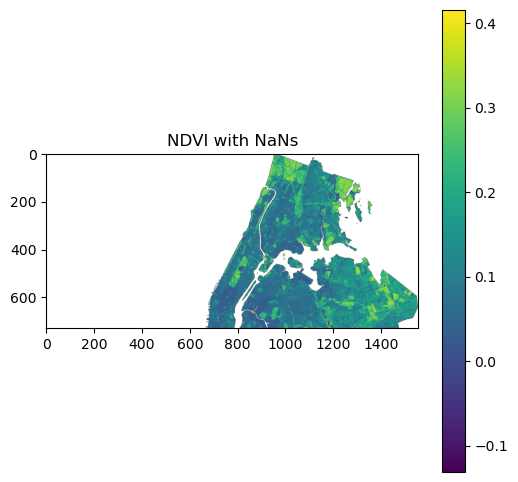

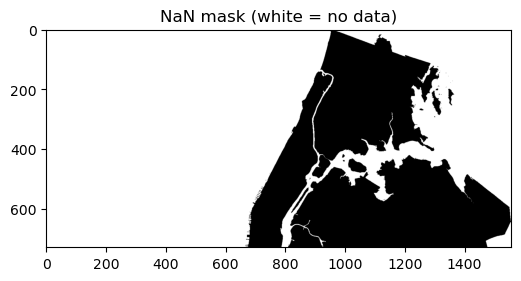

In [20]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

rpath = "data/raster/processed/ndvi_summer_2025.tif"

with rasterio.open(rpath) as src:
    ndvi = src.read(1)
    bounds = src.bounds
    print("Bounds:", bounds)

plt.figure(figsize=(6,6))
plt.imshow(np.where(np.isnan(ndvi), np.nan, ndvi), cmap="viridis")
plt.colorbar()
plt.title("NDVI with NaNs")
plt.show()

# show where the raster is completely missing (NaN mask)
plt.figure(figsize=(6,6))
plt.imshow(np.isnan(ndvi), cmap="gray")
plt.title("NaN mask (white = no data)")
plt.show()
